# Code Review #2 - Stock Data EDA

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

idx = pd.IndexSlice
sns.set_style('whitegrid')

results_path = Path('KR2_results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

## 1. 데이터 불러오기

### Prices, Metadata

In [3]:
prices = pd.read_hdf(results_path / 'data.h5', 'stocks/prices/adjusted')
metadata = pd.read_hdf(results_path / 'data.h5', 'stocks/info').rename(columns=str.lower)

In [4]:
metadata.head(5)

,address1,address2,city,zip,country,phone,fax,website,industry,sector,...,freecashflow,operatingcashflow,earningsgrowth,revenuegrowth,grossmargins,ebitdamargins,operatingmargins,financialcurrency,trailingpegratio,openinterest
005930.KS,129 Samsung-Ro,Maetan-3dong Yeongtong-gu,Suwon-si,443-742,South Korea,82 2 2255 0114,82 3 1200 7538,https://www.samsung.com,Consumer Electronics,Technology,...,-1.345999e+13,5.205390e+13,-0.859,-0.223,0.31972,0.19889,0.06076,KRW,NaN,NaN
373220.KS,"108, Yeoui-daero",Yeongdeungpo-Gu,Seoul,07335,South Korea,82 2 3777 1114,NaN,https://www.lgensol.com,Specialty Industrial Machinery,Industrials,...,-6.875540e+12,1.267587e+12,3.593,0.730,0.15789,0.10627,0.04871,KRW,NaN,NaN
000660.KS,2091 Gyeongchung-daero,Bubal-eup,Icheon-Si,NaN,South Korea,82 31 5185 4114,NaN,https://www.skhynix.com,Semiconductors,Technology,...,-8.570626e+12,4.371575e+12,NaN,-0.471,0.03433,0.23260,-0.21051,KRW,0.621,NaN
207940.KS,"300, Songdo Bio-daero",Yeonsu-gu,Incheon,21987,South Korea,82 3 2455 3114,NaN,https://samsungbiologics.com,Biotechnology,Healthcare,...,-5.206233e+11,1.297787e+12,0.207,0.330,0.49948,0.42886,0.31606,KRW,NaN,0.0
005490.KS,"6261, Donghaean-ro",Nam-gu,Pohang,NaN,South Korea,NaN,NaN,https://www.posco.com,Steel,Basic Materials,...,3.865827e+11,8.028374e+12,-0.530,-0.126,0.06718,0.07870,0.03133,KRW,NaN,NaN


### Select tickers with metadata

In [5]:
sectors = (metadata.sector.value_counts() >= 9).index
tickers_with_errors = []
tickers_with_metadata = metadata[
    metadata.sector.isin(sectors)
    & metadata.marketcap.notnull()
    & metadata.sharesoutstanding.notnull()
    & (metadata.sharesoutstanding > 0)
].index.drop(tickers_with_errors)
metadata = metadata.loc[
    tickers_with_metadata, ["sector", "sharesoutstanding", "marketcap"]
]
metadata.index.name = "ticker"

In [6]:
# Check if 'tickers_with_metadata' contains valid tickers in 'prices' DataFrame
valid_tickers = set(prices.index.get_level_values("ticker"))
tickers_with_metadata = [
    ticker for ticker in tickers_with_metadata if ticker in valid_tickers
]

# Use .loc to select rows based on the tickers_with_metadata list
prices = prices.loc[pd.IndexSlice[tickers_with_metadata, :], :] # type: ignore

In [7]:
close = prices.close.unstack("ticker").sort_index()
volume = prices.volume.unstack("ticker").sort_index()

returns = (
    prices.close.unstack("ticker")
    .resample("W-FRI")
    .last()
    .sort_index()
    .pct_change()
    .iloc[1:]
)

dates = returns.index

with pd.HDFStore(results_path / "autoencoder.h5") as store:
    store.put("close", close)
    store.put("volume", volume)
    store.put("returns", returns)
    store.put("metadata", metadata)

<Axes: xlabel='date'>

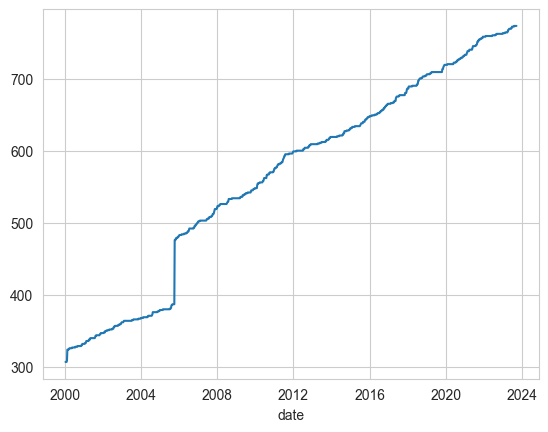

In [8]:
sns.lineplot(returns.count(1))

## Factor Engineering

In [10]:
MONTH = 21

### Price Trend

#### Short-Term Reversal

In [11]:
# 1-month cumulative return
mom1m = close.pct_change(periods=MONTH).resample("W-FRI").last().stack().to_frame("mom1m")  # type: ignore
mom1m.squeeze().to_hdf(results_path / "autoencoder.h5", "factor/mom1m")

#### Stock Momentum

In [12]:
# 11-month cumulative returns ending 1-month before month end
mom12m = (
    close.pct_change(periods=11 * MONTH)
    .shift(MONTH)
    .resample("W-FRI")
    .last()
    .stack()
    .to_frame("mom12m")
)  # type: ignore
mom12m.to_hdf(results_path / 'autoencoder.h5', 'factor/mom12m')

#### Momentum Change

In [13]:
# Cumulative return from months t-6 to t-1 minus months t-12 to t-7.
chmom = (close
         .pct_change(periods=6 * MONTH)
         .sub(close.pct_change(periods=6 * MONTH).shift(6 * MONTH))
         .resample('W-FRI')
         .last()
         .stack()
         .to_frame('chmom')) # type: ignore
chmom.to_hdf(results_path / 'autoencoder.h5', 'factor/chmom')

In [ ]:
#### Industry Momentum
# Equal-weighted avg. industry 12-month returns
indmom = (close.pct_change(12*MONTH)
          .resample('W-FRI')
          .last()
          .stack()
          .to_frame('close') # type: ignore
          .join(metadata[['sector']]).groupby(['date', 'sector'])
          .close.mean()
          .to_frame('indmom')
          .reset_index())
indmom = (returns
          .stack()
          .to_frame('ret') # type: ignore
          .join(metadata[['sector']])
          .reset_index()
          .merge(indmom)
          .set_index(['date', 'ticker'])
          .loc[:, ['indmom']])
indmom.to_hdf(results_path / 'autoencoder.h5', 'factor/indmom')

In [ ]:
#### Recent Max Return
# Max daily returns from calendar month t-1
maxret = (close
           .pct_change(periods=MONTH)
           .rolling(21)
           .max()
           .resample('W-FRI')
           .last()
           .stack()
           .to_frame('maxret')) # type: ignore
maxret.to_hdf(results_path / 'autoencoder.h5', 'factor/maxret')

In [ ]:
#### Long-Term Reversal
# Cumulative returns months t-36 to t-13.
mom36m = (close
           .pct_change(periods=24*MONTH)
           .shift(12*MONTH)
           .resample('W-FRI')
           .last()
           .stack()
           .to_frame('mom36m')) # type: ignore
mom36m.to_hdf(results_path / 'autoencoder.h5', 'factor/mom36m')

### Liquidity Metrics

In [ ]:
#### Turnover
# Avg. monthly trading volume for most recent three months scaled by number
# of shares; we are using the most recent no of shares from yahoo finance
turn = (volume
        .rolling(3*MONTH)
        .mean()
        .resample('W-FRI')
        .last()
        .div(metadata.sharesoutstanding)
        .stack('ticker')
        .to_frame('turn')) # type: ignore
turn.to_hdf(results_path / 'autoencoder.h5', 'factor/turn')

In [ ]:
#### Turnover Volatility
# onthly std dev of daily share turnover
turn_std = (prices
            .volume
            .unstack('ticker')
            .div(metadata.sharesoutstanding)
            .rolling(MONTH)
            .std()
            .resample('W-FRI')
            .last()
            .stack('ticker')
            .to_frame('turn_std')) # type: ignore
turn_std.to_hdf(results_path / 'autoencoder.h5', 'factor/turn_std')

In [ ]:
#### Log Market Equity
# Natural log of market cap at end of month t-1
last_price = close.ffill()
factor = close.div(last_price.iloc[-1])
mvel = np.log1p(factor.mul(metadata.marketcap).resample('W-FRI').last()).stack().to_frame('mvel') # type: ignore
mvel.to_hdf(results_path / 'autoencoder.h5', 'factor/mvel')

In [ ]:
#### KRW Volume
# Natural log of trading volume time price per share from month t-2
dv = close.mul(volume)
krwvol = (np.log1p(dv.rolling(21)
                  .mean()
                  .shift(21)
                  .resample('W-FRI')
                  .last())
          .stack() # type: ignore
          .to_frame('krwvol'))
krwvol.to_hdf(results_path / 'autoencoder.h5', 'factor/krwvol')

In [ ]:
#### Amihud Illiquidity
# Average of daily (absolute return / dollar volume)
ill = (close.pct_change().abs()
       .div(dv)
       .rolling(21)
       .mean()
       .resample('W-FRI').last()
       .stack()
       .to_frame('ill')) # type: ignore
ill.to_hdf(results_path / 'autoencoder.h5', 'factor/ill')

### Risk Measures

In [14]:
#### Return Volatility
# Standard dev of daily returns from month t-1.
retvol = (close.pct_change()
          .rolling(21)
          .std()
          .resample('W-FRI')
          .last()
          .stack()
          .to_frame('retvol')) # type: ignore
retvol.to_hdf(results_path / 'autoencoder.h5', 'factor/retvol')

In [ ]:
#### Market Beta
# Estimated market beta from weekly returns and equal weighted market returns
# for 3 years ending month t-1 with at least 52 weeks of returns.
index = close.resample('W-FRI').last().pct_change().mean(1).to_frame('x')
def get_market_beta(y, x=index):
    df = x.join(y.to_frame('y')).dropna()
    model = RollingOLS(endog=df.y, 
                       exog=sm.add_constant(df[['x']]),
                      window=3*52)
    return model.fit(params_only=True).params['x'] # type: ignore

# 20초
beta = (returns.dropna(thresh=3*52, axis=1)
        .apply(get_market_beta).stack().to_frame('beta')) # type: ignore
beta.to_hdf(results_path / 'autoencoder.h5', 'factor/beta')

In [ ]:
#### Beta Squared
# Market beta squared
betasq = beta.beta.pow(2).to_frame('betasq')
betasq.to_hdf(results_path / 'autoencoder.h5', 'factor/betasq')

In [ ]:
#### Idiosyncratic return volatility
# Standard dev of a regression of residuals of weekly returns
# on the returns of an equal weighted market index returns for the prior three years.
def get_ols_residuals(y, x=index):
    df = x.join(y.to_frame('y')).dropna()
    model = sm.OLS(endog=df.y, exog=sm.add_constant(df[['x']]))
    result = model.fit()
    return result.resid.std()

# 오래 걸림
idiovol = (returns.apply(lambda x: x.rolling(3 * 52)
                         .apply(get_ols_residuals)))
idiovol = idiovol.stack().to_frame('idiovol') # type: ignore
idiovol.to_hdf(results_path / 'autoencoder.h5', 'factor/idiovol')